## Context:
The Open Access Series of Imaging Studies (OASIS) is a project aimed at making MRI data sets of the brain freely available to the scientific community. By compiling and freely distributing MRI data sets, we hope to facilitate future discoveries in basic and clinical neuroscience. OASIS is made available by the Washington University Alzheimer’s Disease Research Center, Dr. Randy Buckner at the Howard Hughes Medical Institute (HHMI)( at Harvard University, the Neuroinformatics Research Group (NRG) at Washington University School of Medicine, and the Biomedical Informatics Research Network (BIRN).
https://www.oasis-brains.org/

## Content:
Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults: This set consists of a cross-sectional collection of 416 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.
Longitudinal MRI Data in Nondemented and Demented Older Adults: This set consists of a longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

In [116]:
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [117]:
oasis_longitudinal = 'oasis_longitudinal.csv'
oasis_longitudinal = pd.read_csv (oasis_longitudinal)
print(oasis_longitudinal.shape)
oasis_longitudinal[oasis_longitudinal.Group == "Converted"].head()

(373, 15)


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,OAS2_0018_MR1,Converted,1,0,F,R,87,14,1.0,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,OAS2_0018_MR3,Converted,3,489,F,R,88,14,1.0,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,OAS2_0018_MR4,Converted,4,1933,F,R,92,14,1.0,27.0,0.5,1423,0.696,1.234
36,OAS2_0020,OAS2_0020_MR1,Converted,1,0,M,R,80,20,1.0,29.0,0.0,1587,0.693,1.106
37,OAS2_0020,OAS2_0020_MR2,Converted,2,756,M,R,82,20,1.0,28.0,0.5,1606,0.677,1.093


In [118]:
oasis_cross_sectional = 'oasis_cross-sectional.csv'
oasis_cross_sectional = pd.read_csv (oasis_cross_sectional)
oasis_cross_sectional.rename(columns={'Educ': 'EDUC'}, inplace=True)
oasis_cross_sectional.head()

,ID,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [119]:
oasis_cross_sectional['CDR'].isnull().sum()

201

In [120]:
oasis_cross_sectional.dropna(subset=['CDR'], inplace=True)

remove unecessary columns from the two dataset

In [121]:
oasis_longitudinal.drop(['Subject ID'], axis = 1, inplace = True, errors = 'ignore')
oasis_longitudinal.drop(['MRI ID'], axis = 1, inplace = True, errors = 'ignore')
oasis_longitudinal.drop(['Visit'], axis = 1, inplace = True, errors = 'ignore')
oasis_longitudinal.drop(['Group'], axis = 1, inplace = True, errors = 'ignore')
oasis_longitudinal.drop(['Hand'], axis = 1, inplace = True, errors = 'ignore')
oasis_longitudinal.drop(['MR Delay'], axis = 1, inplace = True, errors = 'ignore')
oasis_longitudinal.head()

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [122]:
oasis_cross_sectional.drop(['ID'], axis = 1, inplace = True, errors = 'ignore')
oasis_cross_sectional.drop(['Delay'], axis = 1, inplace = True, errors = 'ignore')
oasis_cross_sectional.drop(['Hand'], axis = 1, inplace = True, errors = 'ignore')
oasis_cross_sectional.head()

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [123]:
oasis_cross_sectional.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 415
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     235 non-null    object 
 1   Age     235 non-null    int64  
 2   EDUC    235 non-null    float64
 3   SES     216 non-null    float64
 4   MMSE    235 non-null    float64
 5   CDR     235 non-null    float64
 6   eTIV    235 non-null    int64  
 7   nWBV    235 non-null    float64
 8   ASF     235 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 18.4+ KB


In [124]:
oasis_longitudinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     373 non-null    object 
 1   Age     373 non-null    int64  
 2   EDUC    373 non-null    int64  
 3   SES     354 non-null    float64
 4   MMSE    371 non-null    float64
 5   CDR     373 non-null    float64
 6   eTIV    373 non-null    int64  
 7   nWBV    373 non-null    float64
 8   ASF     373 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 26.4+ KB


join the tow dataset

In [125]:
frames = [oasis_longitudinal, oasis_cross_sectional]
data = pd.concat(frames)

In [126]:
data

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,M,87,14.0,2.0,27.0,0.0,1987,0.696,0.883
1,M,88,14.0,2.0,30.0,0.0,2004,0.681,0.876
2,M,75,12.0,NaN,23.0,0.5,1678,0.736,1.046
3,M,76,12.0,NaN,28.0,0.5,1738,0.713,1.010
4,M,80,12.0,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...
411,F,70,1.0,4.0,29.0,0.5,1295,0.748,1.355
412,F,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
413,F,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
414,M,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


In [127]:
data['CDR'].unique()

array([0. , 0.5, 1. , 2. ])

data preprocessing/ revew nullvalues

In [128]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Lost proportion (%)' :round(data_na,2)})
missing_data

,Lost proportion (%)
SES,6.25
MMSE,0.33


imputation of null values

In [129]:
from sklearn.impute  import SimpleImputer
# We perform it with the most frequent value 
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [130]:
data

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,M,87,14.0,2.0,27.0,0.0,1987,0.696,0.883
1,M,88,14.0,2.0,30.0,0.0,2004,0.681,0.876
2,M,75,12.0,2.0,23.0,0.5,1678,0.736,1.046
3,M,76,12.0,2.0,28.0,0.5,1738,0.713,1.010
4,M,80,12.0,2.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...
411,F,70,1.0,4.0,29.0,0.5,1295,0.748,1.355
412,F,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
413,F,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
414,M,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


label encoder

In [131]:
# 1= M, 0 = F
data['M/F'] = data['M/F'].replace(['M', 'F'], [1,0])  
data.head(3)

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,87,14.0,2.0,27.0,0.0,1987,0.696,0.883
1,1,88,14.0,2.0,30.0,0.0,2004,0.681,0.876
2,1,75,12.0,2.0,23.0,0.5,1678,0.736,1.046


target

In [132]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data['CDR'].values)
le.classes_

array([0. , 0.5, 1. , 2. ])

In [133]:
data['CDR'] = le.transform(data['CDR'].values) 

In [134]:
# The classes are heavily skewed we need to solve this issue later.
print('Label 0 :', round(data['CDR'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Label 0.5 :', round(data['CDR'].value_counts()[1]/len(data) * 100,2), '% of the dataset')
print('Label 1 :', round(data['CDR'].value_counts()[2]/len(data) * 100,2), '% of the dataset')
print('Label 2 :', round(data['CDR'].value_counts()[3]/len(data) * 100,2), '% of the dataset')

Label 0 : 56.09 % of the dataset
Label 0.5 : 31.74 % of the dataset
Label 1 : 11.35 % of the dataset
Label 2 : 0.82 % of the dataset


remove label with values 2

<Axes: xlabel='CDR'>

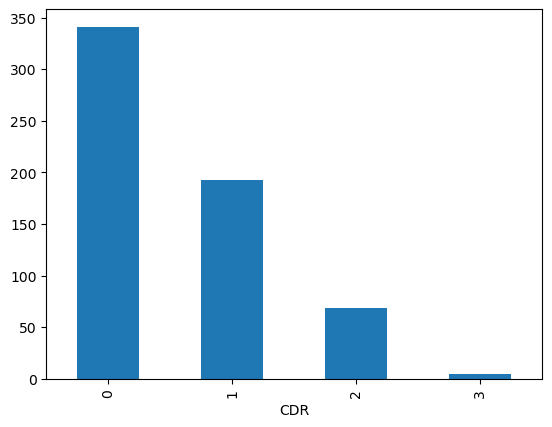

In [135]:
data['CDR'].value_counts().plot(kind = 'bar')

In [136]:
# data = data.drop(data[data['CDR']==3].index)
# data.info()

segmentation

In [137]:
data

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,87,14.0,2.0,27.0,0,1987,0.696,0.883
1,1,88,14.0,2.0,30.0,0,2004,0.681,0.876
2,1,75,12.0,2.0,23.0,1,1678,0.736,1.046
3,1,76,12.0,2.0,28.0,1,1738,0.713,1.010
4,1,80,12.0,2.0,22.0,1,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...
411,0,70,1.0,4.0,29.0,1,1295,0.748,1.355
412,0,73,3.0,2.0,23.0,1,1536,0.730,1.142
413,0,61,2.0,4.0,28.0,0,1354,0.825,1.297
414,1,61,5.0,2.0,30.0,0,1637,0.780,1.072


In [138]:
X = data.drop(["CDR"],axis=1)
y = data["CDR"] #.values # 0,0.5=1,1=2,2=3

<Axes: xlabel='CDR'>

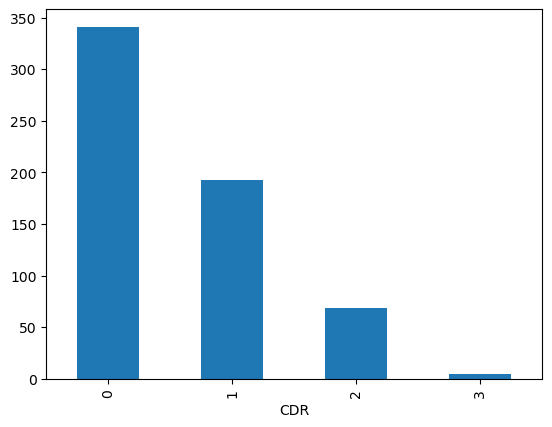

In [139]:
y.value_counts().plot(kind = "bar")

# Balancing the dataset

In [140]:
#import imblearn to balance the classes
import imblearn
from imblearn.over_sampling import SMOTE
from numpy import where
from collections import Counter

counter = Counter(y)
print("##---THE UNSAMPLED DATASET----##\n\n")
print(counter)

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=3)
X,y = oversample.fit_resample(X,y)
counter = Counter(y)
print("\n\n##---THE UNSAMPLED DATASET----##\n\n")
print(counter)

##---THE UNSAMPLED DATASET----##


Counter({0: 341, 1: 193, 2: 69, 3: 5})


##---THE UNSAMPLED DATASET----##


Counter({0: 341, 1: 341, 2: 341, 3: 341})


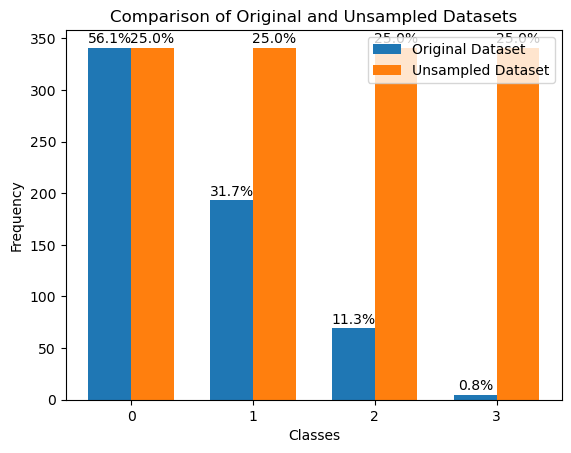

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# The unsampled dataset
unsampled_data = Counter({0: 341, 1: 341, 2: 341, 3: 341})

# The original dataset
original_data = Counter({0: 341, 1: 193, 2: 69, 3: 5})

# Calculate percentages
total_original = sum(original_data.values())
total_unsampled = sum(unsampled_data.values())
percentages_original = [val/total_original*100 for val in original_data.values()]
percentages_unsampled = [val/total_unsampled*100 for val in unsampled_data.values()]

# Plotting the bar chart with percentages
fig, ax = plt.subplots()
bar_width = 0.35
index = list(original_data.keys())
bar1 = ax.bar(index, original_data.values(), bar_width, label='Original Dataset')
bar2 = ax.bar([i + bar_width for i in index], unsampled_data.values(), bar_width, label='Unsampled Dataset')

ax.set_xlabel('Classes')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of Original and Unsampled Datasets')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(index)
ax.legend()

# Add percentages at the top of each bar
for i, val in enumerate(original_data.values()):
    plt.text(i, val+5, f'{percentages_original[i]:.1f}%', ha='center')
for i, val in enumerate(unsampled_data.values()):
    plt.text(i+bar_width, val+5, f'{percentages_unsampled[i]:.1f}%', ha='center')

plt.show()

In [141]:
# Splitting Dataset into Training and Validation Set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,
                                                  random_state=0,
                                                  stratify=y)

print('X Training set', X_train, sep='\n')
print('X Validation set', X_val, sep='\n')
print('y Training set', y_val, sep='\n')
print('y Validation set', y_val, sep='\n')

X Training set
      M/F  Age       EDUC       SES       MMSE  eTIV      nWBV       ASF
603     0   70   1.000000  4.000000  29.000000  1295  0.748000  1.355000
936     0   78  10.019076  2.396185  25.019076  1309  0.714943  1.340010
769     0   73  14.685852  3.000000  22.971221  1352  0.709971  1.297029
972     1   79   6.934128  2.921068  26.539466  1426  0.679395  1.230605
293     0   91  18.000000  2.000000  30.000000  1714  0.741000  1.024000
...   ...  ...        ...       ...        ...   ...       ...       ...
659     0   80   3.169830  2.584915  27.000000  1391  0.706528  1.261245
1209    0   95  16.576010  1.282660  20.152020  1488  0.665653  1.180013
686     1   74   6.947616  2.000000  25.774153  1657  0.732810  1.058835
876     0   73  16.000000  2.565379  23.607729  1357  0.716258  1.293350
940     1   66  16.000000  1.000000  20.461018  1704  0.705156  1.030156

[1023 rows x 8 columns]
X Validation set
      M/F  Age       EDUC       SES       MMSE  eTIV      nWBV     

In [142]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
print(scaled_X_train)
print(scaled_X_val)
print(len(scaled_X_train))
print(len(scaled_X_val))

[[-0.64567601 -0.89008014 -1.55276436 ... -1.24632507  0.80102765
   1.34224869]
 [-0.64567601  0.02665984  0.01382308 ... -1.1511963  -0.04107657
   1.2134551 ]
 [-0.64567601 -0.54630265  0.82442855 ... -0.85901507 -0.16772248
   0.84417717]
 ...
 [ 1.54876438 -0.43171015 -0.51968062 ...  1.21343318  0.41408127
  -1.20231568]
 [-0.64567601 -0.54630265  1.05269218 ... -0.82504051 -0.00757716
   0.81256952]
 [ 1.54876438 -1.34845013  1.05269218 ...  1.53279405 -0.2903879
  -1.44871511]]
[[-0.64567601  1.17258481  0.08726504 ... -0.1591391  -0.92757669
   0.07769675]
 [-0.64567601 -0.66089514 -1.37906726 ... -0.17272893  1.43788096
   0.07926834]
 [-0.64567601 -0.54630265  0.62880836 ... -0.87260489 -0.09360542
   0.86261095]
 ...
 [-0.64567601 -0.89008014 -1.317001   ... -1.14440138  1.0784929
   1.21030312]
 [ 1.54876438 -0.54630265  1.05269218 ... -0.77068121  0.26607088
   0.74942118]
 [-0.64567601 -0.43171015  0.26119515 ...  0.07188791 -0.50738442
  -0.17750732]]
1023
341


# TRIN THE NEURAL NET

In [143]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def evaluate_model(y_val, y_pred):
  """Function to evaluate model and return the metric of the model

  It returns a dictionary with the classification metrics.
  """
  accuracy = accuracy_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred, average='macro')
  recall = recall_score(y_val, y_pred, average='macro')
  f1 = f1_score(y_val, y_pred, average='macro')
  result = {"accuracy_score": accuracy,
            "precision_score": precision,
            "recall_score": recall,
            "f1_score": f1}
  return result

def plot_confusion_matrix(y_val, y_pred, label):
  '''function to plot confusion matrix

  Args
  y_val: array. The validation set of the target variable.
  y_pred: array. Model's prediction.
  label: list. A list containing all the classes in the target variable

  Returns
  It returns a plot of the confusion matrix
  '''
  cm = confusion_matrix(y_val, y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  ConfusionMatrixDisplay(cm, display_labels=label).plot(ax=ax, values_format='', xticks_rotation='vertical')

# class labels
label = ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']

# ann

In [144]:
from tensorflow.keras.utils import to_categorical
# from keras.utils import np_utils

encoded_y_train = to_categorical(y_train)
encoded_y_val = to_categorical(y_val)
encoded_y_train

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [145]:
import tensorflow as tf
print(tf.__version__)

ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(units=12, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=8, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
ann_history = ann_model.fit(scaled_X_train, encoded_y_train, validation_split=0.20, batch_size=16, epochs=150)

2.14.0
Epoch 1/150
52/52 [==============================] - 1s 7ms/step - loss: 1.4193 - accuracy: 0.2494 - precision_9: 0.0769 - recall_9: 0.0012 - val_loss: 1.3549 - val_accuracy: 0.2585 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/150
52/52 [==============================] - 0s 3ms/step - loss: 1.3442 - accuracy: 0.3044 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 1.3070 - val_accuracy: 0.4146 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/150
52/52 [==============================] - 0s 3ms/step - loss: 1.2914 - accuracy: 0.4621 - precision_9: 1.0000 - recall_9: 0.0012 - val_loss: 1.2439 - val_accuracy: 0.5366 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 4/150
52/52 [==============================] - 0s 3ms/step - loss: 1.2114 - accuracy: 0.5086 - precision_9: 1.0000 - recall_9: 0.0367 - val_loss: 1.1443 - val_accuracy: 0.5171 - val_precision_9: 0.8571 - val_recall_9: 0.0585
Epoch 5/150
52/52 [==================

In [146]:
ann_y_pred = ann_model.predict(scaled_X_val)
ann_y_pred = (ann_y_pred > 0.5)
ann_y_pred

11/11 [==============================] - 0s 1ms/step


array([[False, False, False,  True],
       [False,  True, False, False],
       [False, False,  True, False],
       ...,
       [False,  True, False, False],
       [False,  True, False, False],
       [False, False,  True, False]])

In [147]:
# Check the validation accuracy
_, accuracy, precision, recall = ann_model.evaluate(scaled_X_val, encoded_y_val)
print('Accuracy: %.2f' % (accuracy*100))

11/11 [==============================] - 0s 2ms/step - loss: 0.4511 - accuracy: 0.8534 - precision_9: 0.8550 - recall_9: 0.8475
Accuracy: 85.34


Text(0.5, 0, 'epoch')

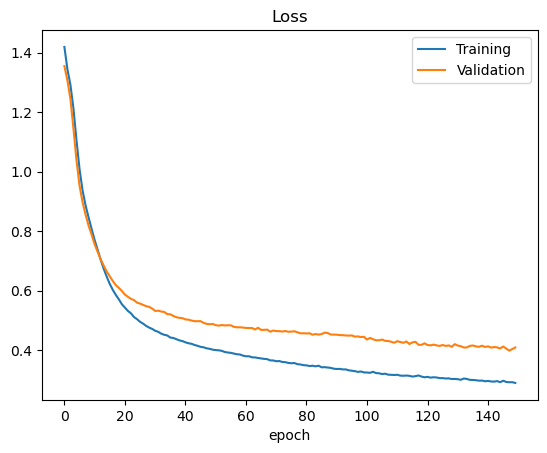

In [148]:
# Plot graph between training and validation loss
plt.plot(ann_history.history['loss'])
plt.plot(ann_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

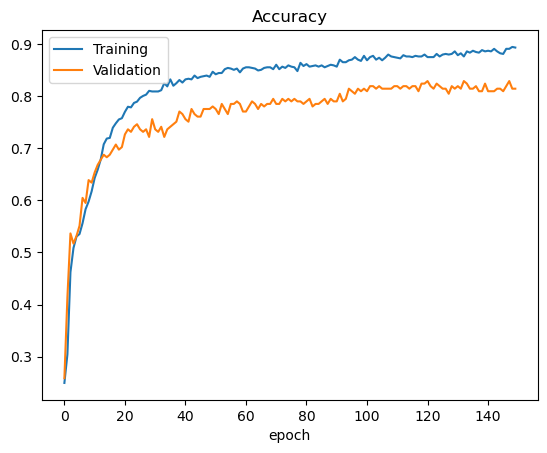

In [149]:
# Plot graph between training and validation accuracy
plt.plot(ann_history.history['accuracy'])
plt.plot(ann_history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

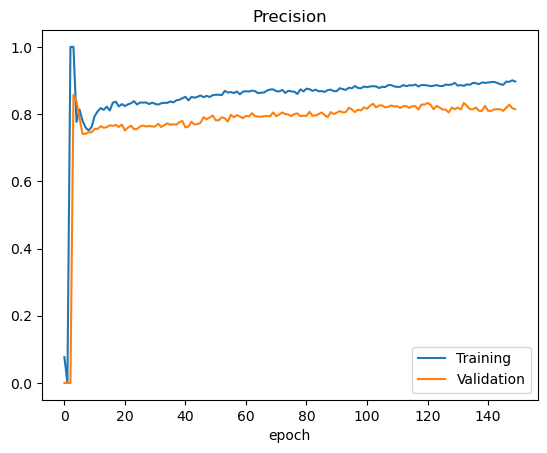

In [151]:
# Plot graph between training and validation precision
plt.plot(ann_history.history['precision_9'])
plt.plot(ann_history.history['val_precision_9'])
plt.legend(['Training', 'Validation'])
plt.title('Precision')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

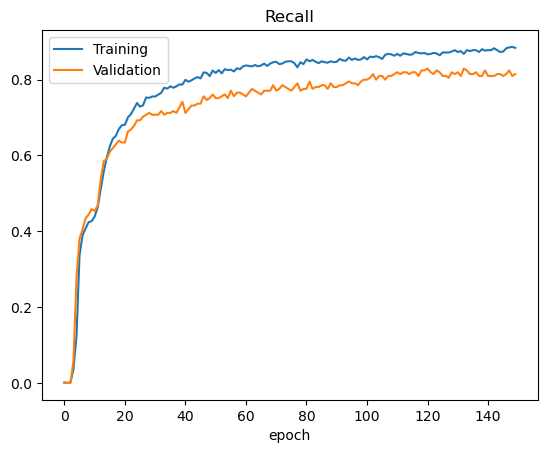

In [152]:
# Plot graph between training and validation recall
plt.plot(ann_history.history['recall_9'])
plt.plot(ann_history.history['val_recall_9'])
plt.legend(['Training', 'Validation'])
plt.title('Recall')
plt.xlabel('epoch')

{'accuracy_score': 0.8533724340175953, 'precision_score': 0.8495081858603749, 'recall_score': 0.8533857729138167, 'f1_score': 0.8508146376394334}
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        86
           1       0.74      0.67      0.70        85
           2       0.86      0.89      0.88        85
           3       0.96      1.00      0.98        85

    accuracy                           0.85       341
   macro avg       0.85      0.85      0.85       341
weighted avg       0.85      0.85      0.85       341



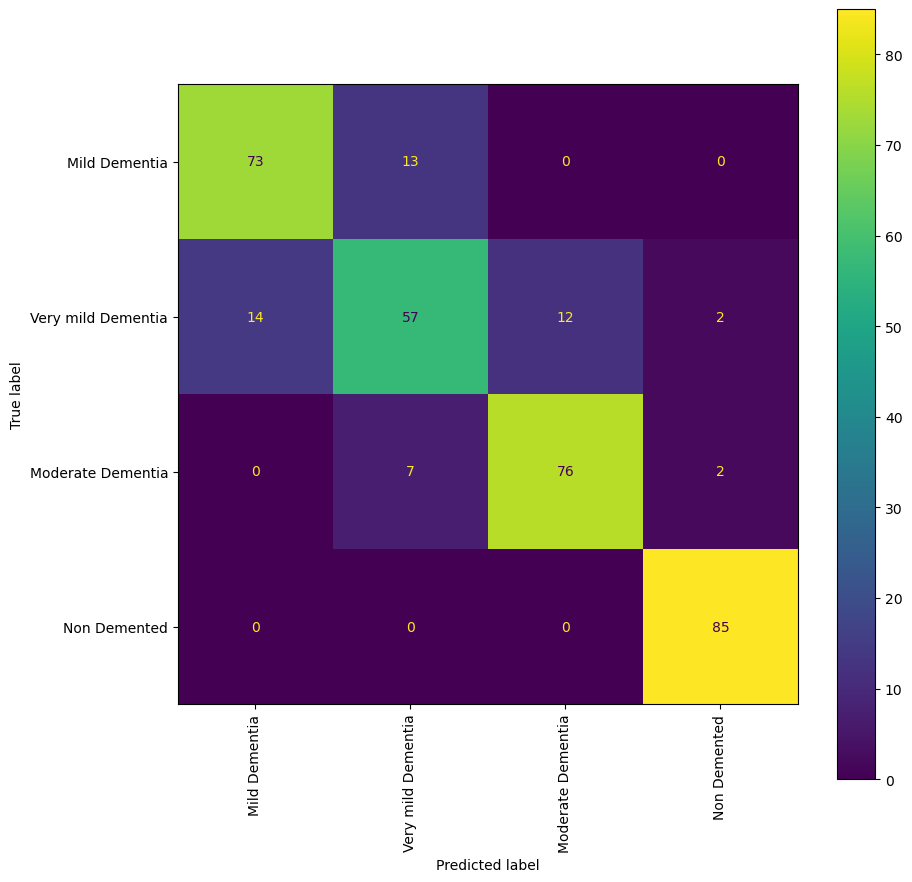

In [153]:
confusion_matrix(encoded_y_val.argmax(axis=1), ann_y_pred.argmax(axis=1)), label
print(evaluate_model(encoded_y_val.argmax(axis=1), ann_y_pred.argmax(axis=1)))
print(classification_report(encoded_y_val.argmax(axis=1), ann_y_pred.argmax(axis=1)))
plot_confusion_matrix(encoded_y_val.argmax(axis=1), ann_y_pred.argmax(axis=1), label)

# Implementing CNN

In [154]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(target_shape=(scaled_X_train.shape[1], 1), input_shape=(scaled_X_train.shape[1],)),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_history = cnn_model.fit(scaled_X_train, encoded_y_train, validation_data=(scaled_X_val, encoded_y_val), batch_size=16, epochs=100)


Epoch 1/100
64/64 [==============================] - 1s 8ms/step - loss: 1.1067 - accuracy: 0.5474 - precision_10: 0.8962 - recall_10: 0.1603 - val_loss: 0.8589 - val_accuracy: 0.6540 - val_precision_10: 0.8103 - val_recall_10: 0.4135
Epoch 2/100
64/64 [==============================] - 0s 3ms/step - loss: 0.7929 - accuracy: 0.6979 - precision_10: 0.8127 - recall_10: 0.4751 - val_loss: 0.6877 - val_accuracy: 0.6921 - val_precision_10: 0.7654 - val_recall_10: 0.5455
Epoch 3/100
64/64 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.7302 - precision_10: 0.8003 - recall_10: 0.6149 - val_loss: 0.5923 - val_accuracy: 0.7390 - val_precision_10: 0.8014 - val_recall_10: 0.6510
Epoch 4/100
64/64 [==============================] - 0s 4ms/step - loss: 0.5827 - accuracy: 0.7537 - precision_10: 0.8096 - recall_10: 0.6774 - val_loss: 0.5625 - val_accuracy: 0.7331 - val_precision_10: 0.7965 - val_recall_10: 0.6657
Epoch 5/100
64/64 [==============================] - 0s 3ms/

In [155]:
cnn_y_pred = cnn_model.predict(scaled_X_val)
cnn_y_pred = (cnn_y_pred > 0.5)
cnn_y_pred

11/11 [==============================] - 0s 2ms/step


array([[False, False, False,  True],
       [False,  True, False, False],
       [False, False,  True, False],
       ...,
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False,  True, False]])

In [156]:
# Check the validation accuracy
_, accuracy, precision, recall = cnn_model.evaluate(scaled_X_val, encoded_y_val)
print('Accuracy: %.2f' % (accuracy*100))

11/11 [==============================] - 0s 3ms/step - loss: 0.4400 - accuracy: 0.8446 - precision_10: 0.8446 - recall_10: 0.8446
Accuracy: 84.46


Text(0.5, 0, 'epoch')

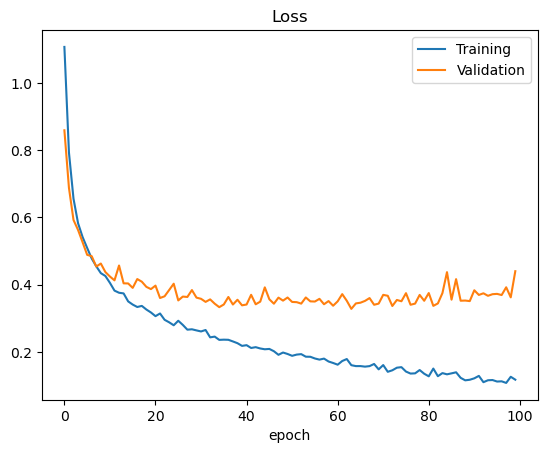

In [157]:
# Plot graph between training and validation loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('epoch')

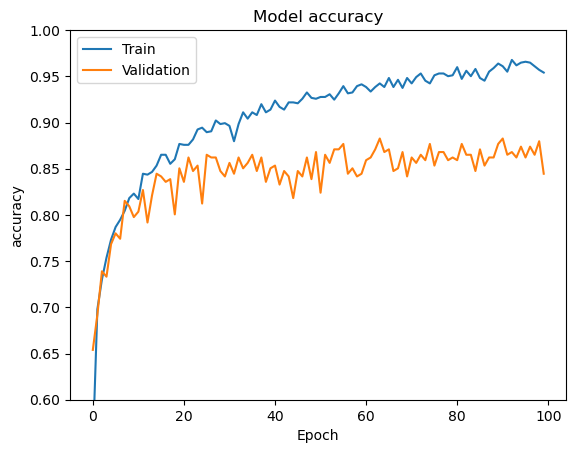

In [158]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.ylim([0.6,1])  # Set the limits of y-axis here
    plt.show()

plot_metrics(cnn_history, 'accuracy')

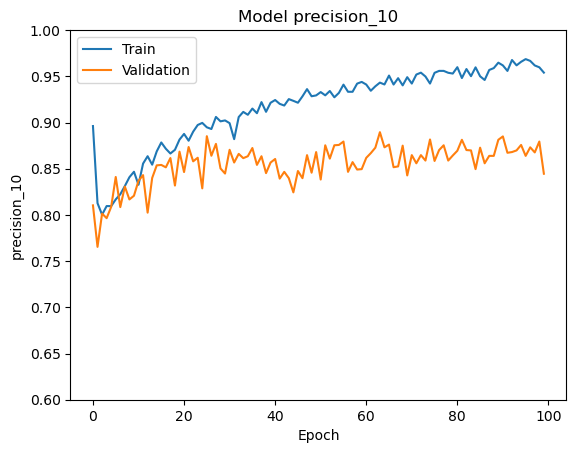

In [159]:
plot_metrics(cnn_history, 'precision_10')

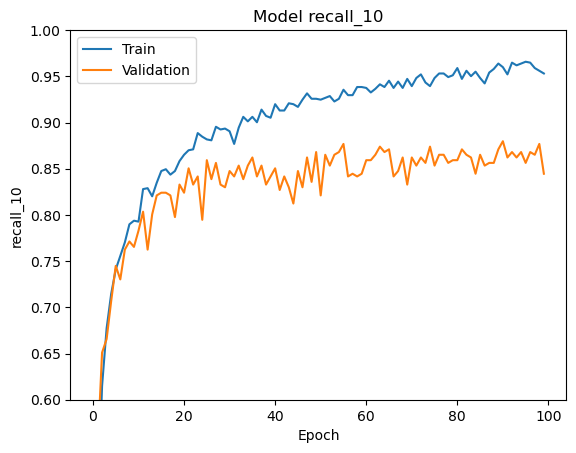

In [160]:
plot_metrics(cnn_history, 'recall_10')

In [161]:
confusion_matrix(encoded_y_val.argmax(axis=1), cnn_y_pred.argmax(axis=1)), label

(array([[75,  9,  2,  0],
        [20, 45, 19,  1],
        [ 0,  1, 83,  1],
        [ 0,  0,  0, 85]]),
 ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented'])

{'accuracy_score': 0.844574780058651, 'precision_score': 0.8456859799305352, 'recall_score': 0.8444938440492477, 'f1_score': 0.8345663489888082}
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        86
           1       0.82      0.53      0.64        85
           2       0.80      0.98      0.88        85
           3       0.98      1.00      0.99        85

    accuracy                           0.84       341
   macro avg       0.85      0.84      0.83       341
weighted avg       0.85      0.84      0.83       341



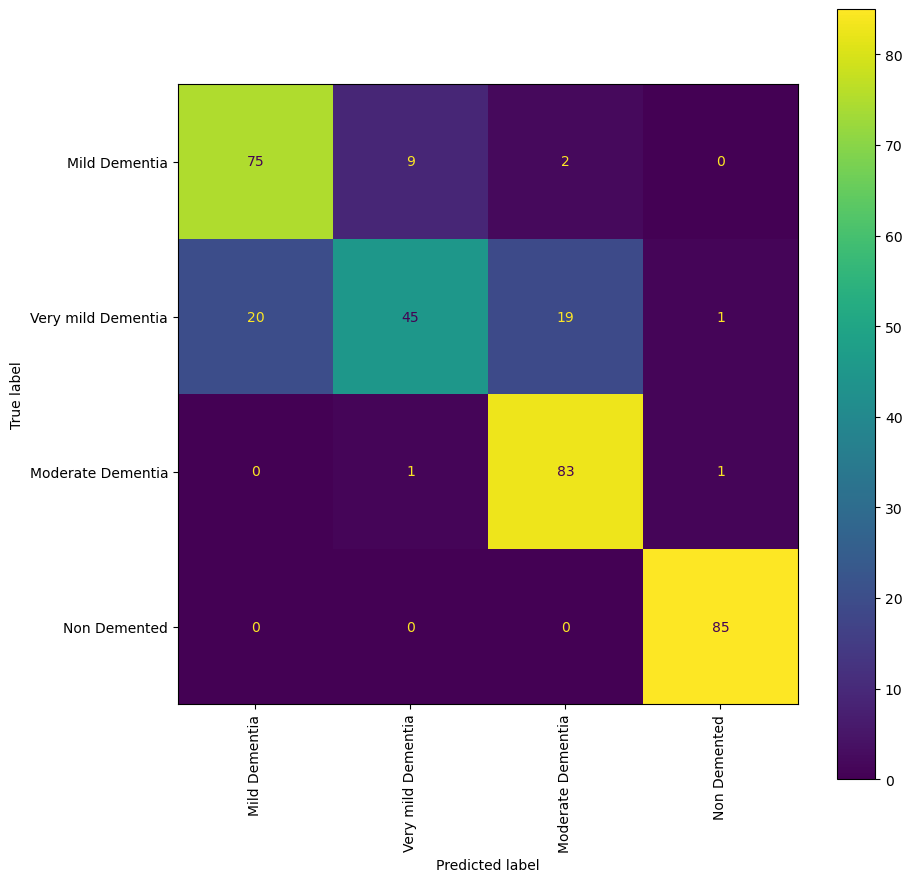

In [162]:
print(evaluate_model(encoded_y_val.argmax(axis=1), cnn_y_pred.argmax(axis=1)))
print(classification_report(encoded_y_val.argmax(axis=1), cnn_y_pred.argmax(axis=1)))
plot_confusion_matrix(encoded_y_val.argmax(axis=1), cnn_y_pred.argmax(axis=1), label)

# Implementing RNN

In [163]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM


rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(target_shape=(scaled_X_train.shape[1], 1), input_shape=(scaled_X_train.shape[1],)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

rnn_history = rnn_model.fit(scaled_X_train, encoded_y_train, validation_data=(scaled_X_val, encoded_y_val), batch_size=16, epochs=150)


Epoch 1/150
64/64 [==============================] - 4s 17ms/step - loss: 1.2057 - accuracy: 0.5220 - precision_11: 0.7015 - recall_11: 0.0459 - val_loss: 1.0044 - val_accuracy: 0.5572 - val_precision_11: 0.5926 - val_recall_11: 0.2346
Epoch 2/150
64/64 [==============================] - 0s 5ms/step - loss: 0.9439 - accuracy: 0.5934 - precision_11: 0.6739 - recall_11: 0.3959 - val_loss: 0.8683 - val_accuracy: 0.6276 - val_precision_11: 0.7205 - val_recall_11: 0.4839
Epoch 3/150
64/64 [==============================] - 0s 5ms/step - loss: 0.8779 - accuracy: 0.6256 - precision_11: 0.7175 - recall_11: 0.4741 - val_loss: 0.8123 - val_accuracy: 0.6129 - val_precision_11: 0.7054 - val_recall_11: 0.4985
Epoch 4/150
64/64 [==============================] - 0s 5ms/step - loss: 0.8368 - accuracy: 0.6413 - precision_11: 0.7252 - recall_11: 0.5210 - val_loss: 0.8436 - val_accuracy: 0.6129 - val_precision_11: 0.6626 - val_recall_11: 0.4780
Epoch 5/150
64/64 [==============================] - 0s 6ms

In [90]:
rnn_y_pred = rnn_model.predict(scaled_X_val)
rnn_y_pred = (rnn_y_pred > 0.5)
rnn_y_pred

11/11 [==============================] - 1s 3ms/step


array([[False, False, False,  True],
       [False,  True, False, False],
       [False, False,  True, False],
       ...,
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False,  True, False]])

In [164]:
# Check the validation accuracy
_, accuracy, precision, recall = rnn_model.evaluate(scaled_X_val, encoded_y_val)
print('Accuracy: %.2f' % (accuracy*100))

11/11 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.8680 - precision_11: 0.8680 - recall_11: 0.8680
Accuracy: 86.80


Text(0.5, 0, 'epoch')

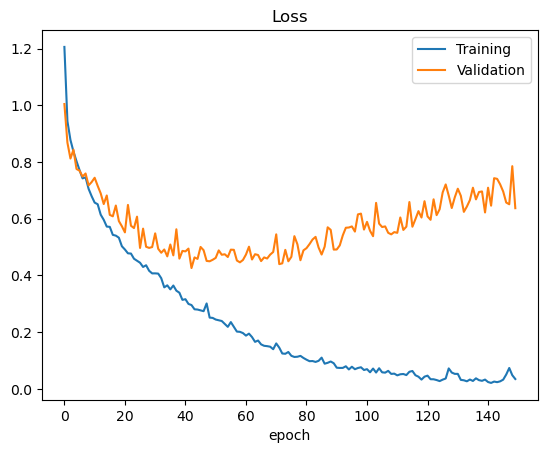

In [165]:
# Plot graph between training and validation loss
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('epoch')

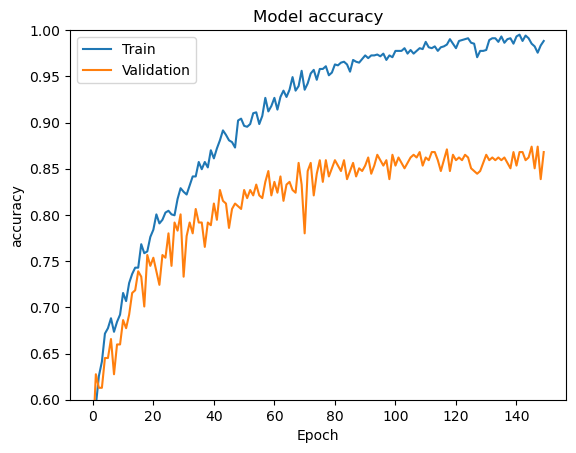

In [166]:
plot_metrics(rnn_history, 'accuracy')

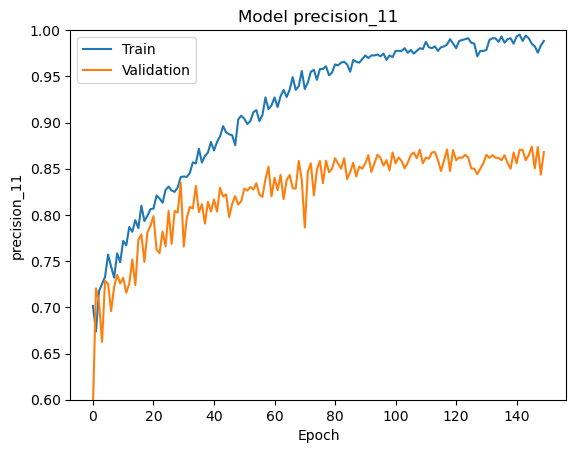

In [168]:
plot_metrics(rnn_history, 'precision_11')

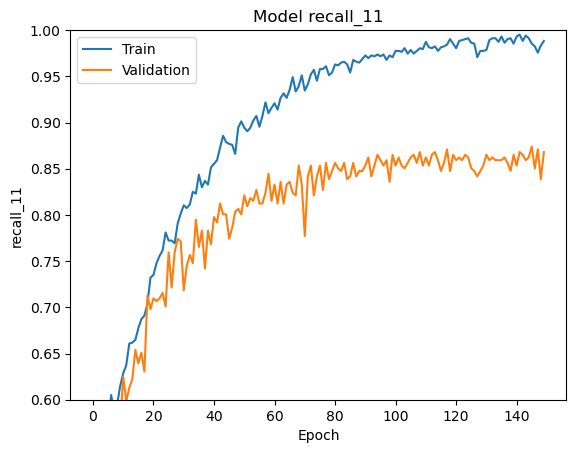

In [169]:
plot_metrics(rnn_history, 'recall_11')

In [170]:
confusion_matrix(encoded_y_val.argmax(axis=1), rnn_y_pred.argmax(axis=1)), label

(array([[71, 12,  3,  0],
        [ 6, 70,  7,  2],
        [ 0,  5, 79,  1],
        [ 0,  0,  0, 85]]),
 ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented'])

{'accuracy_score': 0.8944281524926686, 'precision_score': 0.8950562908936601, 'recall_score': 0.8946306429548563, 'f1_score': 0.8939560172732347}
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        86
           1       0.80      0.82      0.81        85
           2       0.89      0.93      0.91        85
           3       0.97      1.00      0.98        85

    accuracy                           0.89       341
   macro avg       0.90      0.89      0.89       341
weighted avg       0.90      0.89      0.89       341



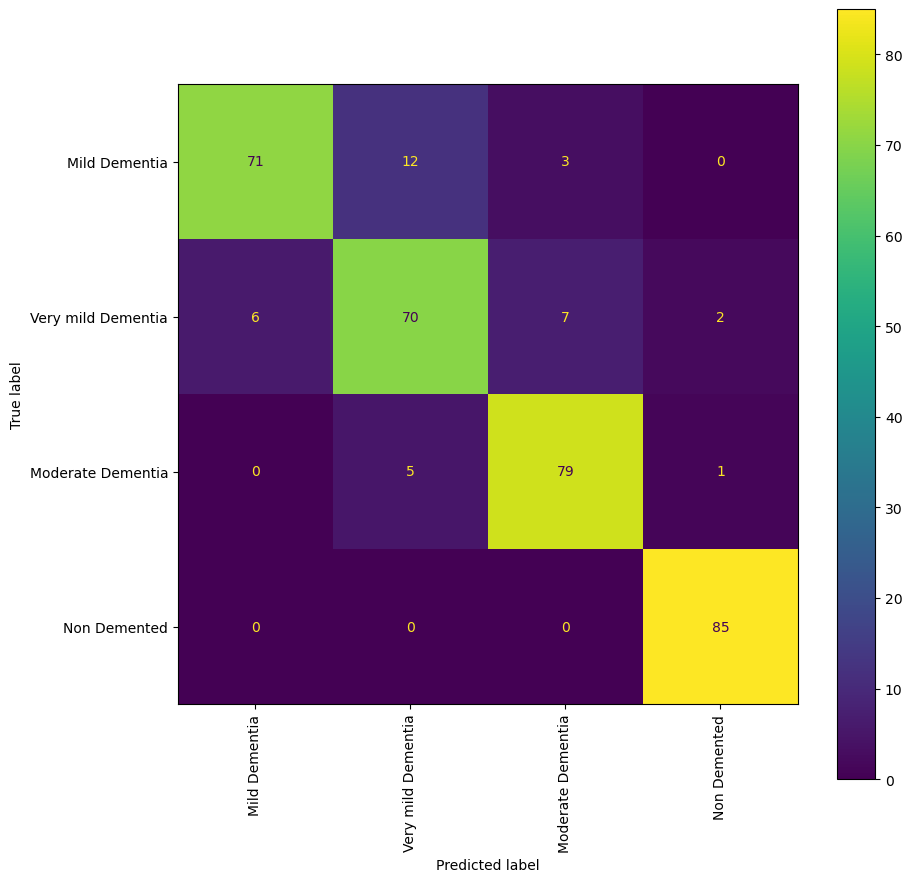

In [171]:
print(evaluate_model(encoded_y_val.argmax(axis=1), rnn_y_pred.argmax(axis=1)))
print(classification_report(encoded_y_val.argmax(axis=1), rnn_y_pred.argmax(axis=1)))
plot_confusion_matrix(encoded_y_val.argmax(axis=1), rnn_y_pred.argmax(axis=1), label)